In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 
import os
from PIL import Image

In [8]:
data = os.listdir('./dataset/')
ford_train = []
ford_test = []
vw_train = []
vw_test = []
size = (128, 128)

# Resize and store training and test images 
for file in data: 
    img = Image.open('./dataset/' + file)
    img = img.resize(size)
    img = np.array(img)
    if file.startswith('ford_train'): 
        ford_train.append(img)
    elif file.startswith('ford_test'):
        ford_test.append(img)
    elif file.startswith('volks_train'): 
        vw_train.append(img)
    elif file.startswith('volks_test'): 
        vw_test.append(img)
        
        
print('{} Ford training images'.format(len(ford_train)))
print('{} Ford training images'.format(len(ford_test)))
print('{} Volkswagen training images'.format(len(vw_train)))
print('{} Volkswagen training images'.format(len(vw_test)))

5 Ford training images
1 Ford training images
5 Volkswagen training images
1 Volkswagen training images


In [39]:
def HoG_features(images, cell_size=(32, 32), block_size=(4, 4), nbins=8):
    features = []
    for img in images: 
        # create HoG Object
        # winSize is the size of the image cropped to an multiple of the cell size
        hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                          img.shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)

        n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

        # Compute HoG features
        hog_feats = hog.compute(img)\
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[0], block_size[1], nbins) \
                       .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

        # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
        # Indexing is by rows then columns.

        # computation for BlockNorm
        gradients = np.full((n_cells[0], n_cells[1], nbins), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_size[0]):
            for off_x in range(block_size[1]):
                gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                          off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                           off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count

        features.append(gradients)

    return features

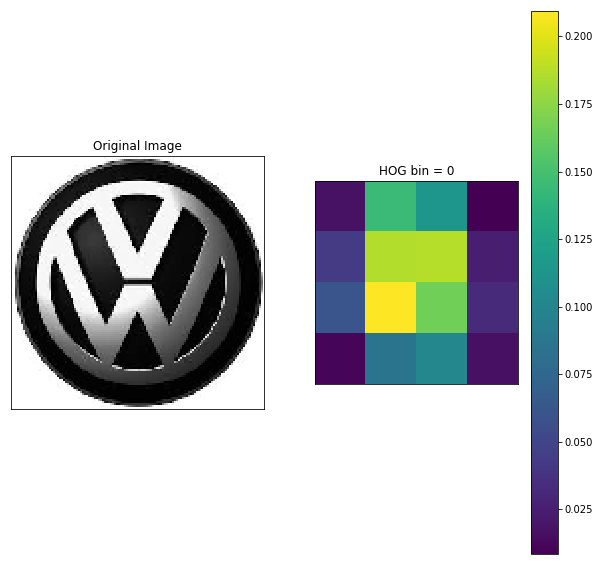

In [40]:
ford_features = HoG_features(ford_train)
vw_features = HoG_features(vw_train)

# test the feature extraction for one image 
img = vw_train[3]
gradients = vw_features[3]

# Preview
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

bin = 0  # angle is 360 / nbins * direction
plt.subplot(122)
plt.pcolor(gradients[:, :, bin])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("HOG bin = 0"), plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()

In [41]:
from sklearn.neighbors import KNeighborsClassifier

# set up classifier
train_x = np.array(ford_features + vw_features)
train_x = train_x.reshape(train_x.shape[0], -1)
nb_ford_train = len(ford_train)
nb_vw_train = len(vw_train)
test_y = [0 for _ in range(nb_ford_train)] + [1 for _ in range(nb_vw_train)]


neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_x, test_y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [42]:
ford_test_features = HoG_features(ford_test)[0]
vw_test_features = HoG_features(vw_test)[0]

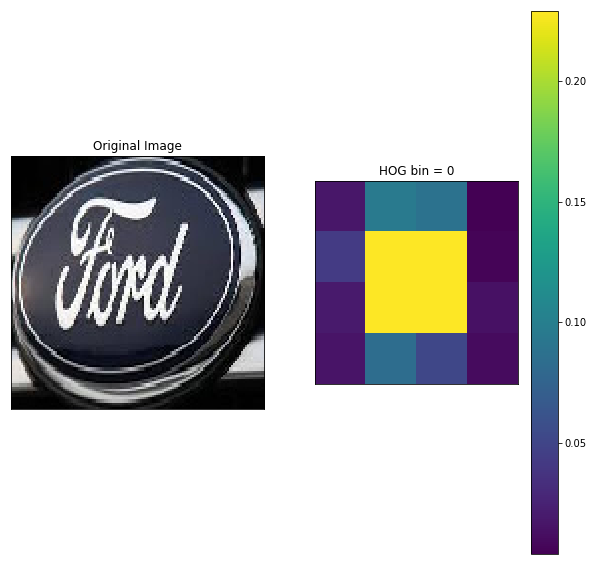

In [43]:
img = ford_test[0]
gradients = ford_test_features

# Preview
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

bin = 0  # angle is 360 / nbins * direction
plt.subplot(122)
plt.pcolor(gradients[:, :, bin])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("HOG bin = 0"), plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()

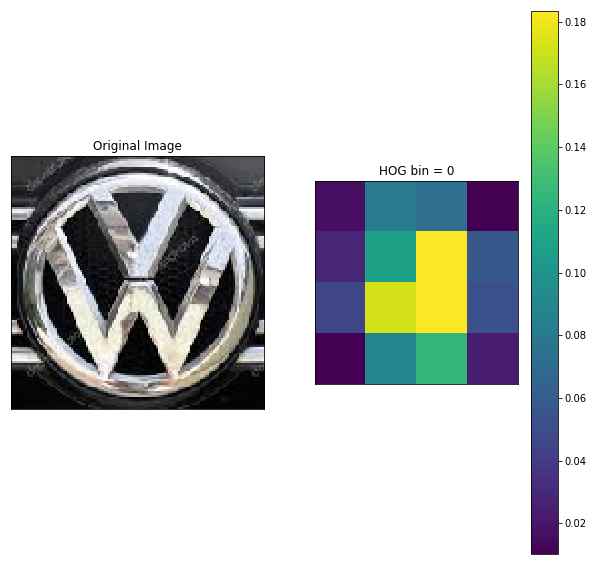

In [44]:
img = vw_test[0]
gradients = vw_test_features

# Preview
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

bin = 0  # angle is 360 / nbins * direction
plt.subplot(122)
plt.pcolor(gradients[:, :, bin])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("HOG bin = 0"), plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()

In [51]:
ford_predict = neigh.predict(ford_test_features.reshape(1, -1))
print(ford_predict)

[0]


In [53]:
vw_predict = neigh.predict(vw_test_features.reshape(1, -1))
print(vw_predict)

[1]
